# Определение токсичности комментариев для «Викишоп» с BERT

### Описание проекта

Интернет-магазин «Викишоп» разрабатывает новый сервис, позволяющий пользователям редактировать и дополнять описания товаров. Подобно вики-сообществам, клиенты могут вносить правки и комментировать их изменения. Для обеспечения корректности взаимодействия необходим инструмент, определяющий токсичные комментарии, которые будут отправляться на модерацию.

Задача — обучить модель, способную классифицировать комментарии на позитивные и негативные, используя доступный набор данных с разметкой токсичности.

Цель — разработать модель с качеством, выраженным через метрику F1, не ниже 0.75.

### План действий

1. Исследовать возможность решения задачи как с использованием BERT, так и без.
2. Загрузить и подготовить данные для анализа.
3. Обучить разные модели и проанализировать их результаты.
4. Сделать выводы по проведенной работе.

### Данные

- Данные хранятся в файле /datasets/toxic_comments.csv.
- В столбце text содержатся тексты комментариев.
- Столбец toxic является целевым признаком, определяющим токсичность комментария.

### Подготовка окружения: глобальные переменные, установка библиотек

In [1]:
!pip install --upgrade scikit-learn==1.2.2 -q
!pip install --upgrade numpy==1.26.4 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade matplotlib==3.8.0 -q
!pip install --upgrade Pillow==9.5.0 -q

In [2]:
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install tqdm -q
!pip install lightgbm -q
!pip install wordcloud -q
!pip install vaderSentiment -q
!pip install nltk -q

Traceback (most recent call last):
  File "c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "c:\Users\taras\anaconda3\envs\practicum\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\urllib3\connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "c:\Users\taras\anaconda3\envs\practicum\lib\site-packages\urllib3\connectionpool.py", line 404, in _make_request
    self._va

In [3]:
import os
import re
from math import log

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from wordcloud import WordCloud, STOPWORDS
from tqdm.notebook import tqdm

import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,  PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier

In [4]:
RANDOM_STATE = 5
TEST_SIZE = 0.25
sns.set_theme()
sns.set_palette('Set2')
tqdm.pandas()

### Знакомство с данными

In [5]:
if os.path.exists('/datasets/toxic_comments.csv'):
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
    print('Success')
elif os.path.exists('./datasets/toxic_comments.csv'):
    df = pd.read_csv('./datasets/toxic_comments.csv', index_col=0)
    print('Success')
else:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

Success


In [6]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.sample(n=5, random_state=11)

,text,toxic
84692,"Thank you, . — Talk/Stalk",0
145306,"I removed the disputed section, which seemed t...",0
1195,"""\n OK,OK! I'm sorry for that too. I won't sen...",0
84962,You're fast \n\nAhhahahaha you're fast. Didn't...,1
1645,""": Er, no, that's not how it works. We do not...",0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
print(f'Количество полных дубликатов в датафрейме {df.duplicated().sum()}')

Количество полных дубликатов в датафрейме 0


Вывод:
- Для работы представлен датасет, в котором преставлены данные о токсичности комментария и сам комментарий
- Среди общего датафрейма не было найдено дубликатов данных

### Исследовательский анализ

Поскольку среди всего датафрейма полных дубликатов найдено не было, рассмотрим есть ли повторяющиеся комментарии пользователей

In [10]:
df.duplicated(subset=['text']).sum()

0

Рассмотрим также распределение таргета для всего датафрейма

In [11]:
def categorial_plot(df: pd.DataFrame, feature: str, feature_ru: str) -> None:
    '''
    Function for plotting categorial distribution
    '''
    data = df[feature].value_counts().to_frame().reset_index()
    if len(data['count'].unique()) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'Распределение для {feature_ru}')
        axes[0].yaxis.grid(True)
        sns.barplot(data=data, x=feature, y='count', ax=axes[0])
        axes[0].set_ylabel('Количество', fontsize=12)
        axes[0].set_xlabel(feature_ru, fontsize=12)
        axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)

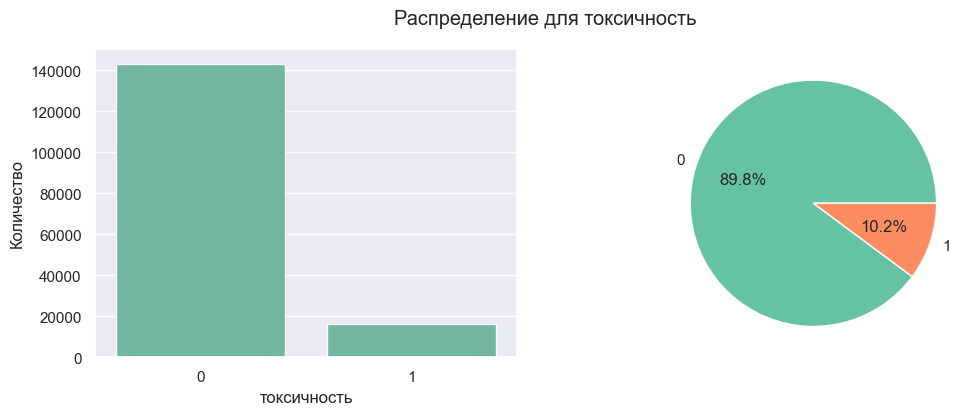

In [12]:
categorial_plot(df, 'toxic', 'токсичность')

Отметим, что в данных наблюдается дисбаланс - 10 процентов целевого признака являются токсичными, тогда как 90 - нетоксичными. Данное распределение является закономерным, поскольку большая часть сообщений - нейтральные или положительные.

# Подготовка данных

Для дальнейшего обучения моделей используем приведение текста к одному типу - уберем специальные символы, а также приведем текст к одному регистру

In [13]:
df['clear_text'] = df['text'].str.lower()
df['clear_text'] = df['clear_text'].apply(lambda x: re.sub(r'[^a-zA-Z.]', ' ', x) if isinstance(x, str) else x)

In [14]:
df.sample(n=5, random_state=11)

,text,toxic,clear_text
84692,"Thank you, . — Talk/Stalk",0,thank you . talk stalk
145306,"I removed the disputed section, which seemed t...",0,i removed the disputed section which seemed t...
1195,"""\n OK,OK! I'm sorry for that too. I won't sen...",0,ok ok i m sorry for that too. i won t sent...
84962,You're fast \n\nAhhahahaha you're fast. Didn't...,1,you re fast ahhahahaha you re fast. didn t w...
1645,""": Er, no, that's not how it works. We do not...",0,er no that s not how it works. we do not...


Теперь данные подготовлены для дальнейшего обучения

Рассмотрим также, какие слова чаще присутствуют в тексте. Для этого посмотрим облако слов: для текстов, помеченных как токсичные и как нет

In [15]:
def create_wordcloud(data, title, column, width=800, height=400, dpi=300, scale=2):
    stopwords = set(STOPWORDS)
    text = " ".join(review for review in data[column])

    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        width=width,
        height=height,
        scale=scale
    ).generate(text)

    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, size=10)
    plt.show()

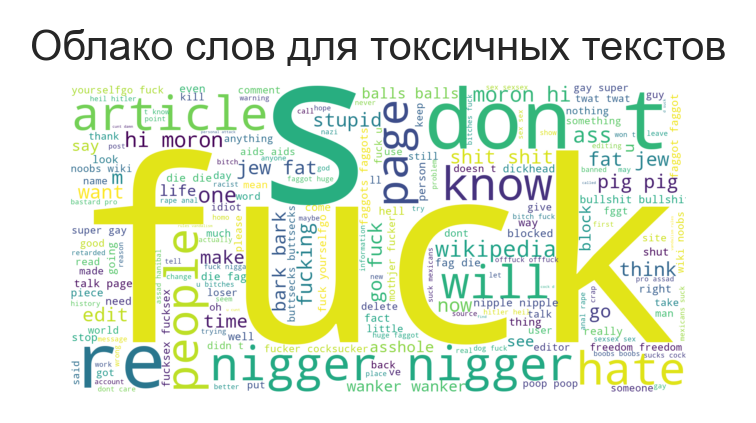

In [16]:
create_wordcloud(df.query('toxic == 1'), 'Облако слов для токсичных текстов', 'clear_text')

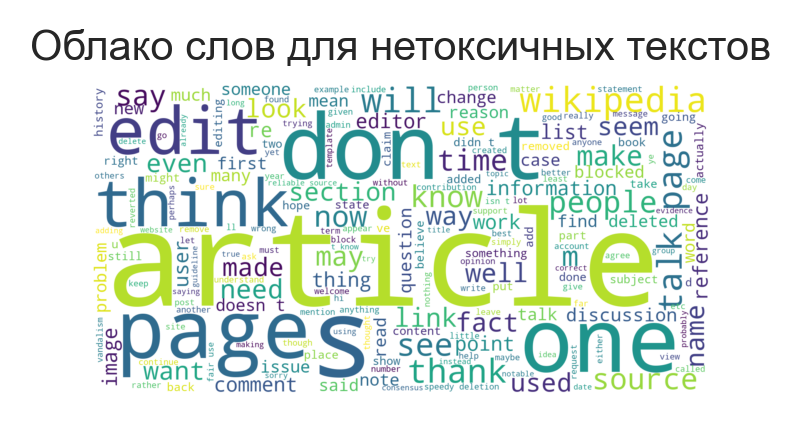

In [17]:
create_wordcloud(df.query('toxic == 0'), 'Облако слов для нетоксичных текстов', 'clear_text')

In [18]:
def word_count(text_series):
    return text_series.str.split().str.len()

def char_count(text_series):
    return text_series.str.len()

def avg_word_length(text_series):
    words_len = text_series[text_series.str.strip() != ""].str.split().apply(lambda x: [len(word) for word in x])
    return words_len.apply(lambda x: np.mean(x) if len(x) > 0 else 0)

def sentiment_score(text_series, analyzer):
    return text_series[text_series.str.strip() != ""].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [19]:
analyzer = SentimentIntensityAnalyzer()

toxic_texts = df[df['toxic'] == 1]['clear_text']
non_toxic_texts = df[df['toxic'] == 0]['clear_text']

toxic_metrics = pd.DataFrame(data={
    'word_count': word_count(toxic_texts),
    'char_count': char_count(toxic_texts),
    'avg_word_length': avg_word_length(toxic_texts),
    'sentiment': sentiment_score(toxic_texts, analyzer)
})

non_toxic_metrics = pd.DataFrame(data={
    'word_count': word_count(non_toxic_texts),
    'char_count': char_count(non_toxic_texts),
    'avg_word_length': avg_word_length(non_toxic_texts),
    'sentiment': sentiment_score(non_toxic_texts, analyzer)
})

In [20]:
print("Описательная статистика для токсичных комментариев")
toxic_metrics.describe()

Описательная статистика для токсичных комментариев


,word_count,char_count,avg_word_length,sentiment
count,16186.000000,16186.000000,16185.000000,16185.000000
mean,54.228593,302.932473,4.515467,-0.410686
std,109.204508,618.647862,14.954431,0.518244
min,0.000000,5.000000,1.000000,-1.000000
25%,11.000000,61.000000,3.800000,-0.831900
50%,24.000000,128.000000,4.166667,-0.566700
75%,52.000000,282.750000,4.565217,0.000000
max,1403.000000,5000.000000,1240.000000,1.000000


In [21]:
print("Описательная статистика для нетоксичных комментариев")
non_toxic_metrics.describe()

Описательная статистика для нетоксичных комментариев


,word_count,char_count,avg_word_length,sentiment
count,143106.000000,143106.000000,143102.000000,143102.000000
mean,69.906775,403.956766,4.524152,0.178122
std,99.782098,585.915713,2.038812,0.544433
min,0.000000,6.000000,1.000000,-1.000000
25%,18.000000,102.000000,4.119403,-0.169500
50%,38.000000,216.000000,4.469697,0.177900
75%,79.000000,452.000000,4.833333,0.659100
max,1250.000000,5000.000000,708.571429,1.000000


На основе приведенной статистики можно отметить, что значения для длины слова, количества слов, а также длины  комментариев отличаются не столь значительно. Это можно заметить по 50% персентилю - для количества слов отношение 1,58 нетоксичных комментариев к токсичным, для количества символов - 1,69, для средней длины слова 1,07. То есть токсичные комментарии в среднем несколько короче.

Для сентимента можно отметить значительную разницу, поскольку категории таргета заметно разделяются нулем.

In [22]:
titles = {
    'word_count': 'Количество слов',
    'char_count': 'Количество символов',
    'avg_word_length': 'Средняя длина слова',
    'sentiment': 'Сентимент'
}

In [23]:
def statictics_words(toxic, no_toxic, titles=titles):
    fig, axes = plt.subplots(4, 1, figsize=(10, 15))

    for idx, (value, key) in enumerate(titles.items()):
        bins = round(log(len(toxic[value]) + 1) * 2)
        sns.histplot(toxic[value], bins=bins, ax=axes[idx], kde=True, label='Токсичные', stat='density')
        sns.histplot(no_toxic[value], bins=bins, ax=axes[idx], kde=True, label='Нетоксичные', stat='density')
        axes[idx].set_title(f'Распределение для {key}')
        axes[idx].set_ylabel('Плотность')
        axes[idx].set_xlabel(key)
        axes[idx].legend(loc='upper right', fontsize='medium')
    
    plt.tight_layout()
    plt.show()

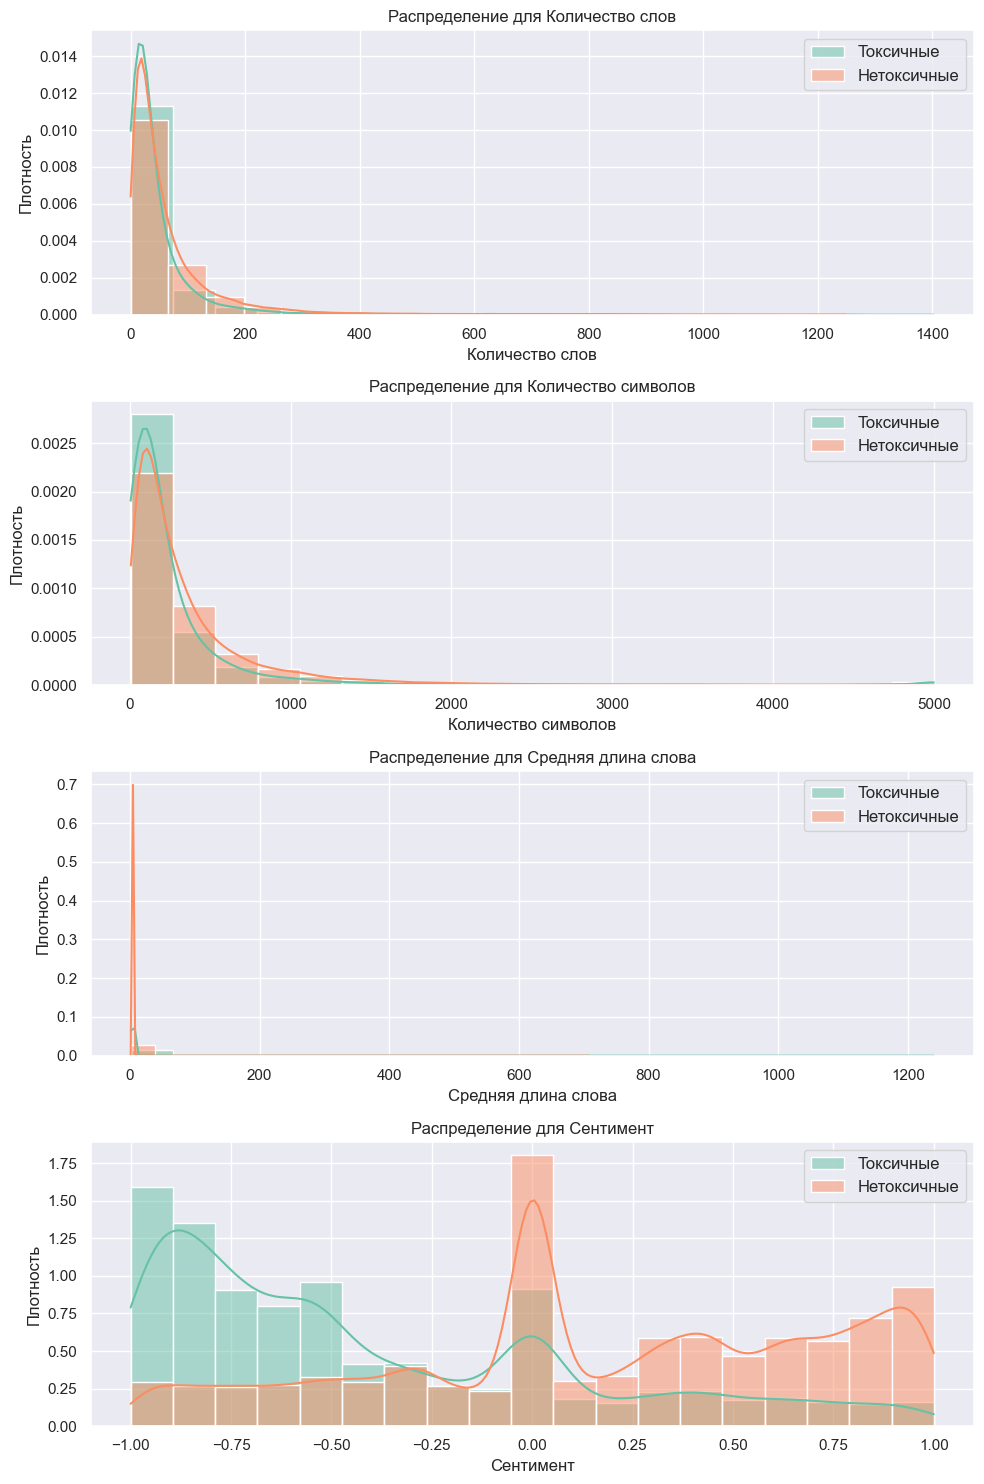

In [24]:
statictics_words(toxic_metrics, non_toxic_metrics)

На графиках можно легко увидеть зависимости сентимента в зависимости от таргета.

Однако, как и отмечалось в описательном анализе, количество символов, количество слов и средняя длина слова отличаются не так значительно

Для экономии ресурсов удалим уже неиспользуемые датафреймы с данными

In [25]:
del toxic_metrics
del non_toxic_metrics
del toxic_texts
del non_toxic_texts
gc.collect()

492

**Вывод**:
- Данные были просмотрены и проанализированы для дальнейшейшего обучения моделей. Можно отметить, что:
    - Текст для анализа представлен на английском
    - Таргет не сбалансирован - токсичных комментариев в 9 раз меньше, чем не токсичных. Это необходимо учитывать при обучении модели
- В качестве анализа было:
    - для каждого вида таргета построено облако слов
    - Рассчитаны средняя длина слова, количество слов в предложениях(твитах) и количество твитов в них, а также сентимент. На основе полученных данных были рассчитаны и выведены в датафрейме полученные значения, а также построены графики для оценки распределения обоих таргетов. Из-за дисбаланса было решено использовать нормализацию для получения объективной оценки данных. Можно отметить, что длина слов и другие параметры не так сильно зависят от таргета, в отличии от сентимента. 
- Подготовка данных:
    - Для дальнейшего обучения была проведена очистка текста

## Лемматизация текста

Проведем лемматизацию текста с помощью библиотеки `spacy`.

In [26]:
def calculate_proportion(data: pd.DataFrame, name: str = 'toxic') -> None:
    vc = (data[name].value_counts()/len(data[name])* 100).round(1)
    print(f'Процентное отношение комментариев с негативной окраской: {vc[1]}')
    print(f'Процентное отношение комментариев с положительной окраской: {vc[0]}')

In [27]:
calculate_proportion(df)

Процентное отношение комментариев с негативной окраской: 10.2
Процентное отношение комментариев с положительной окраской: 89.8


Поскольку наш объем данных слишком большой, уменьшим его до 25000 примеров для обучения BERT

In [28]:
def downsample(n_samples: int, data: pd.DataFrame) -> pd.DataFrame:
    return data.groupby('toxic').apply(lambda x: x.sample(n=int(n_samples * len(x) / len(data)))).reset_index(drop=True)

In [29]:
df_bert = downsample(25000, df)

In [30]:
calculate_proportion(df_bert)
print(f'Количество строчек в датафрейме {len(df_bert)}')

Процентное отношение комментариев с негативной окраской: 10.2
Процентное отношение комментариев с положительной окраской: 89.8
Количество строчек в датафрейме 24999


In [31]:
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes(["parser", "ner"])

def process_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(lemmas)

def parallel_process_texts(texts, func):
    n_threads = os.cpu_count()
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        results = list(tqdm(executor.map(func, texts), total=len(texts), desc="Обработка текстов"))
    return results

Проверим, что все корректно работает на ограниченной выборке данных

In [32]:
df_reduced = downsample(100, df)

In [33]:
print("Начало обработки текста...")
df_reduced['processed_text'] = parallel_process_texts(df_reduced['clear_text'], process_text)
print("Обработка текста завершена.")

Начало обработки текста...


Обработка текстов:   0%|          | 0/99 [00:00<?, ?it/s]

Обработка текста завершена.


In [34]:
df_reduced.head()

,text,toxic,clear_text,processed_text
0,"""\n\n Ginger Jolie \n\nI found your comments i...",0,ginger jolie i found your comments in th...,ginger jolie find comment deletion discussion ...
1,How about leave you bias out of this article? ...,0,how about leave you bias out of this article ...,leave bias article think s easy ten people con...
2,"""\n\n{{unblock-auto|1=212.219.59.241|2=Autoblo...",0,unblock auto . . . autoblock...,unblock auto autoblocke ip address recently ra...
3,Your evasion of your 1 month block has been no...,0,your evasion of your month block has been no...,evasion month block note
4,Now corrected; heave => heavy.,0,now corrected heave heavy.,correct heave heavy


Здесь используем флаг, чтобы при невыполнении конкретно данной ячейки читался файл с уже обработанными данными

In [35]:
process_text_final = 0
print("Начало обработки текста...")
df['processed_text'] = parallel_process_texts(df['clear_text'], process_text)
print("Обработка текста завершена.")
process_text_final = 1

Начало обработки текста...


Обработка текстов:   0%|          | 0/159292 [00:00<?, ?it/s]

Обработка текста завершена.


In [36]:
if process_text_final:
    df.to_csv('processed_tweets.csv', index=False)

In [37]:
df.head()

,text,toxic,clear_text,processed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m s...,d aww match background colour m seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war. it...,hey man m try edit war s guy constantly remove...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on im...,t real suggestion improvement wonder section s...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero. any chance you remember...,sir hero chance remember page s


# Обучение моделей

В качестве решений используем модели с предобучением (BERT), а также простые модели (Линейная регрессия) и модели с использовванием градиентного спуска (CatBoost и LGMT) с признаками, полученными через TF-IDF

In [38]:
if not process_text_final:
    df_reduced = pd.read_csv('processed_tweets.csv')
    df_reduced.dropna(inplace=True)

Проверим еще раз на пропуски перед обучением моделей и использования TF-IDF

In [39]:
df_reduced.isna().sum()

text              0
toxic             0
clear_text        0
processed_text    0
dtype: int64

## Обучение с использованием TF-IDF

In [40]:
nltk.download("stopwords")
stopwords = set(nltk_stopwords.words("english"))


X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['toxic'], test_size=TEST_SIZE, stratify=df['toxic'], random_state=RANDOM_STATE
)

tfidf = TfidfVectorizer(max_features=10000, stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
X_train.sample(5)

40893     gurjar revert edit gurjar gurjar second large ...
81653     read criticism read criticism mean read dismis...
49782     yes person add lot good stuff page revert expl...
114993                   hi wow geek bullshit mother fucker
147841    people s gosh t speak english claim mother ton...
Name: processed_text, dtype: object

Тексты прошли лемматизацию и были подготовлены к обучению модели при помощи TF-IDF

### Pipeline для обучения

In [42]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'tfidf__max_features': [2000, 5000, 10000],
        'tfidf__ngram_range': [(2, 2), (1, 3)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [10, 20, 30]
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'tfidf__max_features': [2000, 5000, 10000],
        'tfidf__ngram_range': [(2, 2), (1, 3)],
        'model__C': [0.1, 1, 10],
        'model__max_iter': [200, 500]
    },
    {
        'model': [PassiveAggressiveClassifier(random_state=RANDOM_STATE)],
        'tfidf__max_features': [2000, 5000, 10000],
        'tfidf__ngram_range': [(2, 2), (1, 3)],
        'model__C': [0.01, 0.1, 1],
        'model__max_iter': [200, 500]
    }
]

model_search = RandomizedSearchCV(pipeline, 
                                 param_grid, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 scoring='f1',
                                 verbose=1,
                                 n_iter=20,
                                 random_state=RANDOM_STATE)

model_search.fit(X_train, y_train)

print(f"Best parameters: {model_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12139, number of negative: 107330
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.032943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 620589
[LightGBM] [Info] Number of data points in the train set: 119469, number of used features: 9160
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101608 -> initscore=-2.179485
[LightGBM] [Info] Start training from score -2.179485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

In [43]:
search_result = pd.DataFrame(model_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)
search_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__max_features,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,...,param_model__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,1264.601947,37.183969,22.366404,9.073181,"(1, 3)",10000,100,10,0.2,"LGBMClassifier(learning_rate=0.2, max_depth=10...",...,NaN,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.738822,0.748121,0.727947,0.750610,0.743333,0.741767,0.008009,1
1,357.830592,3.505740,20.487887,0.744035,"(1, 3)",5000,NaN,NaN,NaN,PassiveAggressiveClassifier(random_state=5),...,0.01,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.733333,0.738258,0.723923,0.750611,0.740247,0.737275,0.008735,2
14,1220.039877,70.235914,27.877833,4.928427,"(1, 3)",2000,200,20,0.2,"LGBMClassifier(learning_rate=0.2, max_depth=10...",...,NaN,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.732835,0.727360,0.725694,0.746610,0.738765,0.734253,0.007692,3
2,750.380791,38.254342,21.262466,3.819576,"(1, 3)",2000,100,10,0.1,"LGBMClassifier(learning_rate=0.2, max_depth=10...",...,NaN,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.696342,0.700894,0.690647,0.716667,0.699254,0.700761,0.008684,4
12,1066.934931,43.963115,32.641054,12.101753,"(1, 3)",10000,50,20,0.1,"LGBMClassifier(learning_rate=0.2, max_depth=10...",...,NaN,"{'tfidf__ngram_range': (1, 3), 'tfidf__max_fea...",0.693059,0.703788,0.689920,0.718481,0.686143,0.698278,0.011687,5


In [44]:
model_search.best_params_

{'tfidf__ngram_range': (1, 3),
 'tfidf__max_features': 10000,
 'model__n_estimators': 100,
 'model__max_depth': 10,
 'model__learning_rate': 0.2,
 'model': LGBMClassifier(learning_rate=0.2, max_depth=10, random_state=5)}

In [45]:
model_search.best_score_

0.7417665580697859

## Обучение с BERT

Обучение с BERT не удалось запустить на локальном ноутбуке, однако получилось обучить в google colab. [Ссылка](https://colab.research.google.com/drive/1V8DTOWz_MygYDN8bgk7bhMJKjqmFG8iI?usp=sharing)

Результат f1-score на валидационной выборке 0.78 (скрин приложен)

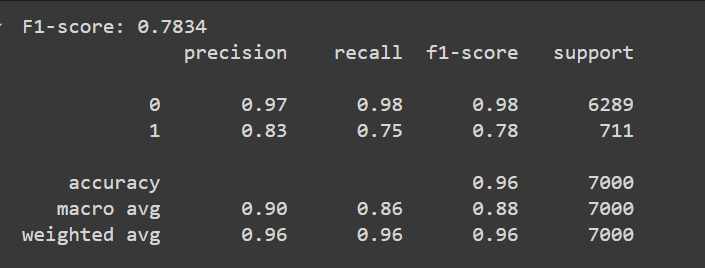

В качестве модели была использована предобученная модель BERT для классификации предложениями с двумя классами, а также предобученный токенизатор, в который загружается уже предобработанный текст.

# Тестирование моделей

По итогам сравнения результатов на валидационной выборке, было принято решение использовать модель BERT, которая показала выше результат на валидационной выборке - 0.78 по метрике f1-score

Было проведено тестирование модели на тестировочной выборке и результат показал 0.78 на метрике f1-score, что удовлетворяет требованиям заказчика
Скрин с результатами представлен ниже

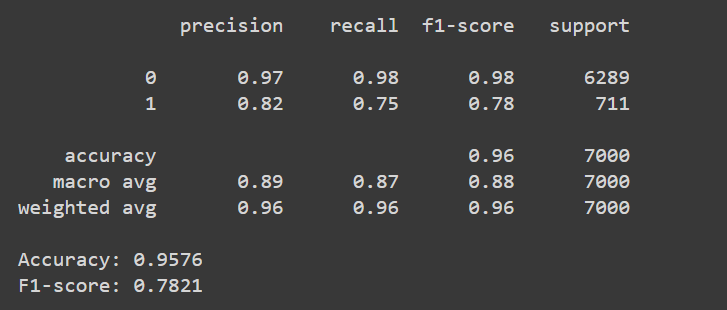

**Вывод:**
- проект включал различные шаги обучения, а именно:
  - Анализ данных:
    - Текст для анализа представлен на английском
    - Таргет не сбалансирован - токсичных комментариев в 9 раз меньше, чем не токсичных. Это необходимо учитывать 
    - для каждого вида таргета построено облако слов
    - Рассчитаны средняя длина слова, количество слов в предложениях(твитах) и количество твитов в них, а также сентимент. На основе полученных данных были рассчитаны и выведены в датафрейме полученные значения, а также построены графики для оценки распределения обоих таргетов. Из-за дисбаланса было решено использовать нормализацию для получения объективной оценки данных. Можно отметить, что длина слов и другие параметры не так сильно зависят от таргета, в отличии от сентимента. 
  - поиск дубликатов, анализ распределения таргета
  - Очистка текста, лемматизация
  - Определение признаков TF-IDF для дальнейшего обучения
при обучении модели    
- Подготовка данных:
    - Для дальнейшего обучения была проведена очистка текста
- В результате работы были обучены модели логистической регрессии, Catboost, LGBM и BERT. Лучший результат на тестовой выборке был получен при помощи предобученной модели BERT, лучший результат - 0.78 для метрики F1-score на тестовой выборке